In [1]:
import warnings

warnings.filterwarnings("ignore")

# 1. 数据集处理

数据集处理是大模型训练前的重要准备工作，涉及数据收集、清洗、去重和增强等环节。

## 1.1 数据收集

### 1.1.1 数据来源

- **公开语料库**：如Common Crawl、C4、The Pile、Wikipedia等
- **专业领域文献**：学术论文、专业书籍、技术文档
- **互联网数据**：网页、社交媒体、论坛、问答平台
- **多模态数据**：图像-文本对、视频描述、语音转录
- **代码仓库**：GitHub、GitLab等开源代码平台
- **结构化数据**：企业数据库、公开数据集

In [ ]:
import pandas as pd
import numpy as np
import requests
import os
from datasets import load_dataset
from huggingface_hub import HfApi

In [ ]:
# 演示从不同公开渠道获取数据集

# 1. 从Hugging Face获取数据集
print("1. 从Hugging Face获取数据集")
# 加载GLUE基准测试中的SST-2情感分析数据集
sst2_dataset = load_dataset("glue", "sst2")
print(f"SST-2数据集大小: 训练集 {len(sst2_dataset['train'])}条, 验证集 {len(sst2_dataset['validation'])}条")
print(f"示例: {sst2_dataset['train'][0]}")
print("-" * 50)

In [ ]:
# 2. 从Kaggle获取数据集 (需要Kaggle API凭证)
print("2. 从Kaggle获取数据集 (示例代码)")
"""
# 需要先配置Kaggle API凭证
!pip install kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"your_username","key":"your_api_key"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# 下载数据集
!kaggle datasets download -d kazanova/sentiment140
!unzip sentiment140.zip
"""
print("Kaggle提供了大量高质量数据集，需要注册账号并获取API凭证")
print("-" * 50)

In [ ]:
# 3. 从UCI机器学习仓库获取数据集
print("3. 从UCI机器学习仓库获取数据集")
uci_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
try:
    iris_data = pd.read_csv(uci_url, header=None, names=column_names)
    print(f"Iris数据集大小: {len(iris_data)}条记录")
    print(f"数据集前3条: \n{iris_data.head(3)}")
except:
    print("无法连接UCI仓库，请检查网络连接")
print("-" * 50)

Wikipedia API，请检查网络连接")
print("-" * 50)

In [ ]:
# 4. 从Wikipedia获取数据
print("4. 从Wikipedia获取数据")
wiki_api_url = "https://zh.wikipedia.org/w/api.php"
params = {
    "action": "query",
    "format": "json",
    "titles": "人工智能",
    "prop": "extracts",
    "exintro": True,
    "explaintext": True,
}
try:
    response = requests.get(wiki_api_url, params=params)
    data = response.json()
    page_id = list(data["query"]["pages"].keys())[0]
    extract = data["query"]["pages"][page_id]["extract"]
    print(f"Wikipedia '人工智能'词条摘要 (前200字符):\n{extract[:200]}...")
except:
    print("无法连接

In [ ]:
# 5. 浏览Hugging Face上可用的大型语料库
print("5. 浏览Hugging Face上可用的大型语料库")
api = HfApi()
try:
    datasets = api.list_datasets(filter="language:zh", limit=5)
    print("Hugging Face上的中文数据集示例:")
    for dataset in datasets:
        print(f" - {dataset.id}: {dataset.description[:100]}...")
except:
    print("无法连接Hugging Face API，请检查网络连接")

### 1.1.2 数据采样策略

- **平衡采样**：确保不同领域和类别的数据均衡表示
- **质量加权采样**：根据数据质量指标对样本进行加权
- **时间序列采样**：考虑数据的时间分布，避免过时信息
- **难度梯度采样**：由易到难的课程学习模式

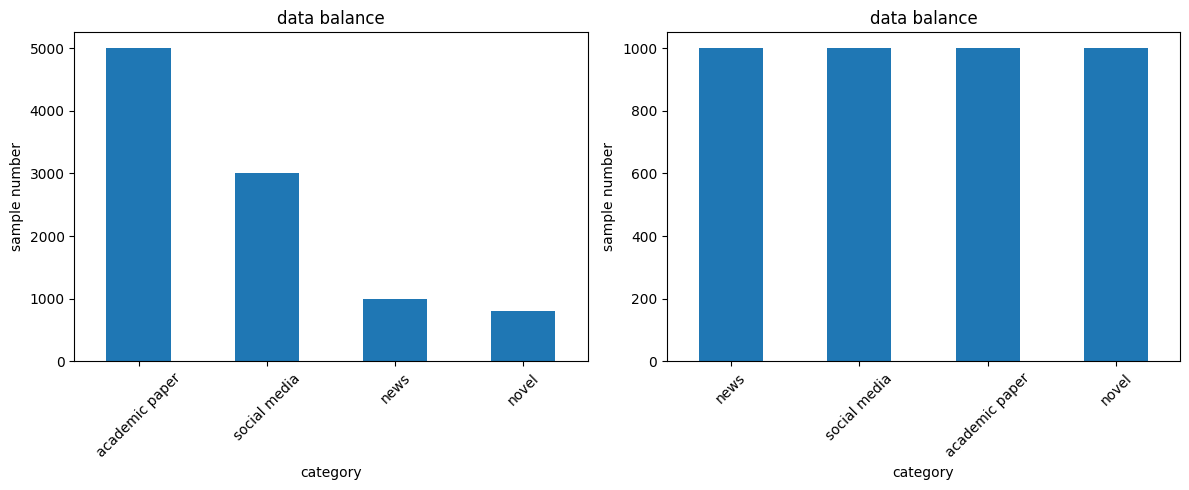

平衡采样前后对比:
原始数据集大小: 9800 样本
平衡后数据集大小: 4000 样本

各类别样本数量:
                原始数量  平衡后数量
category                   
academic paper  5000   1000
news            1000   1000
novel            800   1000
social media    3000   1000


In [5]:
# 演示平衡采样策略
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

# 创建一个不平衡的示例数据集
np.random.seed(42)
categories = ['news', 'social media', 'academic paper', 'novel']
# 不平衡数据分布
original_counts = [1000, 3000, 5000, 800, 1200]
original_data = []

for i, category in enumerate(categories):
    for _ in range(original_counts[i]):
        original_data.append({'category': category, 'text_length': np.random.normal(500 + i*100, 100)})

df = pd.DataFrame(original_data)

# 可视化原始不平衡数据分布
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df['category'].value_counts().plot(kind='bar', title='data balance')
plt.ylabel('sample number')
plt.xticks(rotation=45)

# 执行平衡采样
# 确定目标样本数（取最小类别的样本数或自定义数量）
target_samples = 1000

# 平衡采样
balanced_data = []
for category in categories:
    category_data = df[df['category'] == category]
    # resample 是 sklearn 中的一个函数，用于对数据进行重采样, 它可以根据给定的样本数量和类别，对数据进行上采样或下采样。
    # 对于样本量大的类别，进行下采样
    if len(category_data) > target_samples:
        resampled = resample(category_data, 
                            replace=False,
                            n_samples=target_samples,
                            random_state=42)
    # 对于样本量小的类别，进行上采样: 
    else:
        resampled = resample(category_data, 
                            replace=True,
                            n_samples=target_samples,
                            random_state=42)
    balanced_data.append(resampled)

balanced_df = pd.concat(balanced_data)

# 可视化平衡后的数据分布
plt.subplot(1, 2, 2)
balanced_df['category'].value_counts().plot(kind='bar', title='data balance')
plt.ylabel('sample number')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("平衡采样前后对比:")
print(f"原始数据集大小: {len(df)} 样本")
print(f"平衡后数据集大小: {len(balanced_df)} 样本")
print("\n各类别样本数量:")
print(pd.DataFrame({
    '原始数量': df['category'].value_counts().sort_index(),
    '平衡后数量': balanced_df['category'].value_counts().sort_index()
}))


## 1.2 数据清洗

### 1.2.1 文本数据清洗

- **基础清洗**
  - 去除HTML、XML标签
  - 统一编码格式(UTF-8)
  - 修正明显的拼写错误
  - 规范化空白字符和标点符号

- **高级清洗**
  - 内容质量过滤（如基于困惑度筛选）
  - 去除低信息量内容
  - 识别并处理违规有害内容
  - 去除机器生成的低质量文本

### 1.2.2 去重技术

- **精确去重**：基于哈希值(MD5/SHA)的完全匹配
- **近似去重**：MinHash、SimHash等局部敏感哈希算法
- **语义去重**：基于向量相似度的去重方法
- **跨语言去重**：对翻译或相似内容的跨语言检测


In [27]:
# 演示去重技术的实现

# 创建一个包含重复数据的示例数据集
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import hashlib

# 创建示例数据
texts = [
    "人工智能正在改变我们的生活方式",
    "我们的生活方式正被人工智能所改变",
    "人工智能正在改变我们的生活方式",  # 完全重复
    "AI is changing our way of life",  # 英文版本
    "人工智能正在影响我们的日常生活",  # 相似内容
    "机器学习是人工智能的一个子领域",
    "深度学习是机器学习的一种方法",
    "深度学习是机器学习的一个方法"
]

df_duplicate = pd.DataFrame({'text': texts})
print(f"原始数据集大小: {len(df_duplicate)} 条文本")

原始数据集大小: 8 条文本


In [29]:
# 1. 精确去重 - 基于哈希值
def exact_deduplication(df, text_column):
    # 计算每个文本的哈希值
    df['text_hash'] = df[text_column].apply(lambda x: hashlib.md5(x.encode()).hexdigest())
    # 去除重复的哈希值
    df_unique = df.drop_duplicates(subset=['text_hash'])
    return df_unique

df_exact_dedup = exact_deduplication(df_duplicate.copy(), 'text')
print(f"精确去重后数据集大小: {len(df_exact_dedup)} 条文本")

精确去重后数据集大小: 7 条文本


In [33]:
# 2. 近似去重 - 基于TF-IDF和余弦相似度
def semantic_deduplication(df, text_column, similarity_threshold=0.8):
    texts = df[text_column].tolist()
    
    # 使用TF-IDF向量化文本
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # 计算文本间的余弦相似度
    similarity_matrix = cosine_similarity(tfidf_matrix)
    
    # 标记要保留的索引
    indices_to_keep = []
    for i in range(len(texts)):
        # 如果当前索引已经在要保留的列表中，跳过
        if i in indices_to_keep:
            continue

        for j in indices_to_keep:
            # 如果相似度高于阈值且j不在要保留的列表中，则不添加j
            if similarity_matrix[i, j] > similarity_threshold:
                print(f"发现相似文本:\n{texts[i]}\n{texts[j]}\n相似度: {similarity_matrix[i, j]:.2f}")
                break
            else:
                # print(f"相似对比: {texts[i]} 和 {texts[j]} 相似度: {similarity_matrix[i, j]:.2f}")
                pass
        else:
            # 将当前索引添加到要保留的列表中
            indices_to_keep.append(i)
        
        
    # 返回去重后的数据框
    return df.iloc[indices_to_keep].reset_index(drop=True)

df_semantic_dedup = semantic_deduplication(df_duplicate.copy(), 'text')
print(f"语义去重后数据集大小: {len(df_semantic_dedup)} 条文本")

# 展示去重后的结果
print("\n语义去重后保留的文本:")
for i, text in enumerate(df_semantic_dedup['text']):
    print(f"{i+1}. {text}")

发现相似文本:
人工智能正在改变我们的生活方式
人工智能正在改变我们的生活方式
相似度: 1.00
语义去重后数据集大小: 7 条文本

语义去重后保留的文本:
1. 人工智能正在改变我们的生活方式
2. 我们的生活方式正被人工智能所改变
3. AI is changing our way of life
4. 人工智能正在影响我们的日常生活
5. 机器学习是人工智能的一个子领域
6. 深度学习是机器学习的一种方法
7. 深度学习是机器学习的一个方法


## 1.3 数据增强

- **基于规则的增强**
  - 同义词替换
  - 回译(Back Translation)
  - 文本修改与重组
  - EDA(Easy Data Augmentation)

- **基于模型的增强**
  - 使用小型语言模型生成变体
  - 对抗样本生成
  - 风格转换
  - 知识增强与注入

## 1.4 数据混合与配比

- **语料库混合策略**：不同来源数据的混合比例设计
- **任务导向混合**：根据下游任务需求调整数据分布
- **领域适配混合**：针对特定垂直领域的数据配比
- **语言平衡混合**：多语言模型的语言数据比例